In [346]:
sys.path.insert(1, '../../')
import numpy as np, sys, os, pandas as pd
from getting_data import read_conf
import matplotlib.pyplot as plt
from s2search_score_pdp import pdp_based_importance

def get_Z_by_flist(f_list):
    print()
    print(f_list)
    print()
    Z = np.zeros([len(f_list), len(f_list)])

    # load interaction from 2 way ale
    for i in range(len(f_list)):
        f1_name = f_list[i]
        for j in range(i + 1, len(f_list)):
            f2_name = f_list[j]
            
            f1_f2_file = os.path.join('.', 'scores', f'{sample_name}_2w_ale_{f1_name}_{f2_name}.npz')
            f2_f1_file = os.path.join('.', 'scores', f'{sample_name}_2w_ale_{f2_name}_{f1_name}.npz')
            
            file = f1_f2_file if os.path.exists(f1_f2_file) else f2_f1_file

            nparr = np.load(file)
            ale_result = nparr['ale_result']
            
            Z[j][i] = np.std(ale_result, ddof=1)
            Z[i][j] = np.std(ale_result, ddof=1)

    # load importance from 1 way ale
    for row_col in range(len(f_list)):
        feature_name = f_list[row_col]
        file = os.path.join('.', 'scores', f'{sample_name}_1w_ale_{feature_name}.npz')
        if os.path.exists(file):
            nparr = np.load(file)
            ale_result = nparr['ale_result']
            Z[row_col][row_col] = pdp_based_importance(ale_result, feature_name)
            
    return Z

In [347]:
pd.set_option('display.expand_frame_repr', False)

sample_name = 'cslg'

old_list = [
    'title', 
    'abstract', 
    'venue', 
    'authors', 
    'year', 
    'n_citations'
]

Z = get_Z_by_flist(old_list)

for a in Z:
    print(a)

def get_wi_order(z):
    order = []
    col = 0
    for row in z:
        vi = row[col]
        sij = np.max([x for x in row if x != vi])
        order.append({
            'feature_name': old_list[col],
            'wi': vi + sij
        })
        col += 1
    
    order.sort(key=lambda x: x['wi'], reverse=True)
    
    return [x['feature_name'] for x in order]

sorted_f_list = get_wi_order(Z / np.linalg.norm(Z))

Z = get_Z_by_flist(sorted_f_list)

for a in Z:
    print(a)

sorted_f_list = [x.title() for x in sorted_f_list]


['title', 'abstract', 'venue', 'authors', 'year', 'n_citations']

[2.38272238 5.9339073  0.26258771 0.21191652 0.14668095 0.05615048]
[5.9339073  5.66480512 0.63095577 0.18811802 0.08802665 0.02947286]
[0.26258771 0.63095577 1.31665432 0.13040584 0.0030742  0.00612804]
[0.21191652 0.18811802 0.13040584 1.32719623 0.00534545 0.01149588]
[0.14668095 0.08802665 0.0030742  0.00534545 0.43333752 0.18050249]
[0.05615048 0.02947286 0.00612804 0.01149588 0.18050249 0.23645584]

['abstract', 'title', 'venue', 'authors', 'year', 'n_citations']

[5.66480512 5.9339073  0.63095577 0.18811802 0.08802665 0.02947286]
[5.9339073  2.38272238 0.26258771 0.21191652 0.14668095 0.05615048]
[0.63095577 0.26258771 1.31665432 0.13040584 0.0030742  0.00612804]
[0.18811802 0.21191652 0.13040584 1.32719623 0.00534545 0.01149588]
[0.08802665 0.14668095 0.0030742  0.00534545 0.43333752 0.18050249]
[0.02947286 0.05615048 0.00612804 0.01149588 0.18050249 0.23645584]


/var/folders/6x/97rwqn7x1xn6pgv1ynsqvc9h0000gn/T/ipykernel_26204/2574383622.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted_f_list, fontsize=16)
/var/folders/6x/97rwqn7x1xn6pgv1ynsqvc9h0000gn/T/ipykernel_26204/2574383622.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.flip(sorted_f_list), fontsize=14)


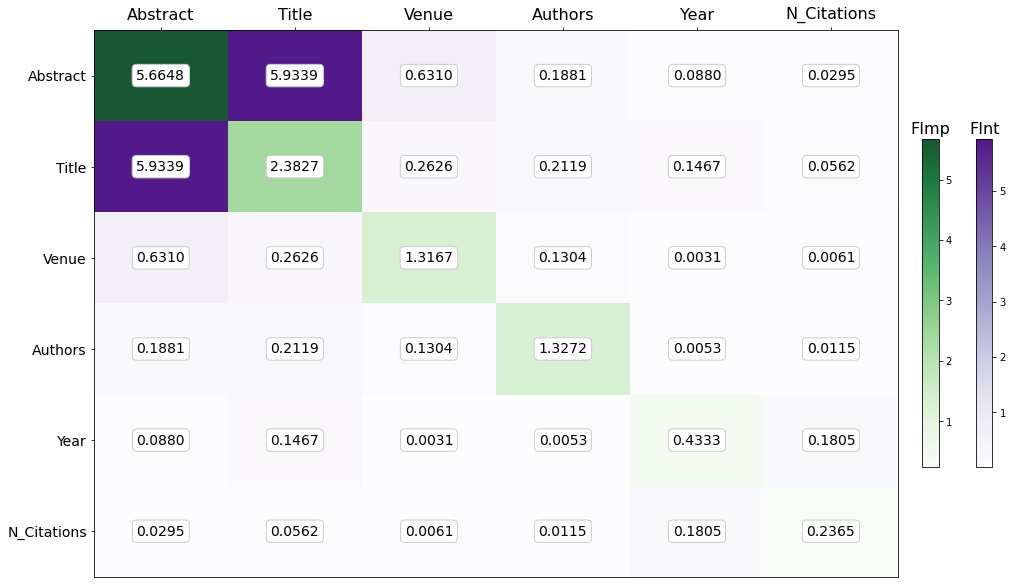

In [348]:
mask= np.array([
    [1,0,0,0,0,0],
    [0,1,0,0,0,0],
    [0,0,1,0,0,0],
    [0,0,0,1,0,0],
    [0,0,0,0,1,0],
    [0,0,0,0,0,1]
]).astype(bool)

z1 = np.copy(Z)
z1[mask] = np.nan

z2 = np.copy(Z)
z2[~mask] = np.nan

z1 = np.flipud(z1)
z2 = np.flipud(z2)

fig, ax = plt.subplots(figsize=(14, 8), constrained_layout=True)

ax.xaxis.tick_top()
ax.set_xticklabels(sorted_f_list, fontsize=16)
ax.set_yticklabels(np.flip(sorted_f_list), fontsize=14)

map1 = ax.pcolormesh(sorted_f_list, np.flip(sorted_f_list), z1,  cmap='Purples', alpha=0.9)
map2 = ax.pcolormesh(sorted_f_list, np.flip(sorted_f_list), z2,  cmap='Greens', alpha=0.9)

map1cb = fig.colorbar(map1, ax=ax, shrink=0.6, pad=0.03)
map1cb.ax.set_title('FInt', size=16)
map2cb = fig.colorbar(map2, ax=ax, shrink=0.6, pad=0.03)
map2cb.ax.set_title('FImp', size=16)

for (i, j), z in np.ndenumerate(np.flipud(Z)):
    ax.text(j, i, '{:0.4f}'.format(z), ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.8'), size=14)
